In [1]:
import numpy as np
import cv2 as cv2
import moviepy as mov
import matplotlib.pyplot as plt
%matplotlib inline
import proglog
proglog.notebook()

In [49]:
import time

In [2]:
cv2.__version__

'3.4.2'

# Extracting Text From Video

In [3]:
!ls

ScreenRecording_01-08-2019 23-21-21.MP4 east-text-detection.ipynb
Untitled.py                             frozen_east_text_detection.pb
Untitled1.ipynb                         opencv-text-detection


In [271]:
path = 'ScreenRecording_01-08-2019 23-21-21.MP4'
cap = cv2.VideoCapture(path)

In [334]:
fps = cap.get(cv2.CAP_PROP_FPS)

In [335]:
total_num_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print(f'file: {path}, # frames: {total_num_of_frames}, '
      f'WxH: {width}x{height}, fps: {fps}')

file: ScreenRecording_01-08-2019 23-21-21.MP4, # frames: 1444.0, WxH: 886x1920, fps: 59.395352025776376


Showing an image. Why must be it be so difficult after over 5 decades of computers.

In [273]:
def set_frame_idx(idx):
    global cap
    if idx >= 0 and idx <= total_num_of_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        return cap.read()

In [315]:
val, frame = set_frame_idx(0)
height, width = frame.shape[:2]
cv2.imwrite('videp-cap.jpg', frame)

True

In [285]:
import PIL.Image

In [276]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [277]:
frame = cv2.imread('opencv-text-detection/images/lebron_james.jpg')
height, width = frame.shape[:2]
width,height

(600, 500)

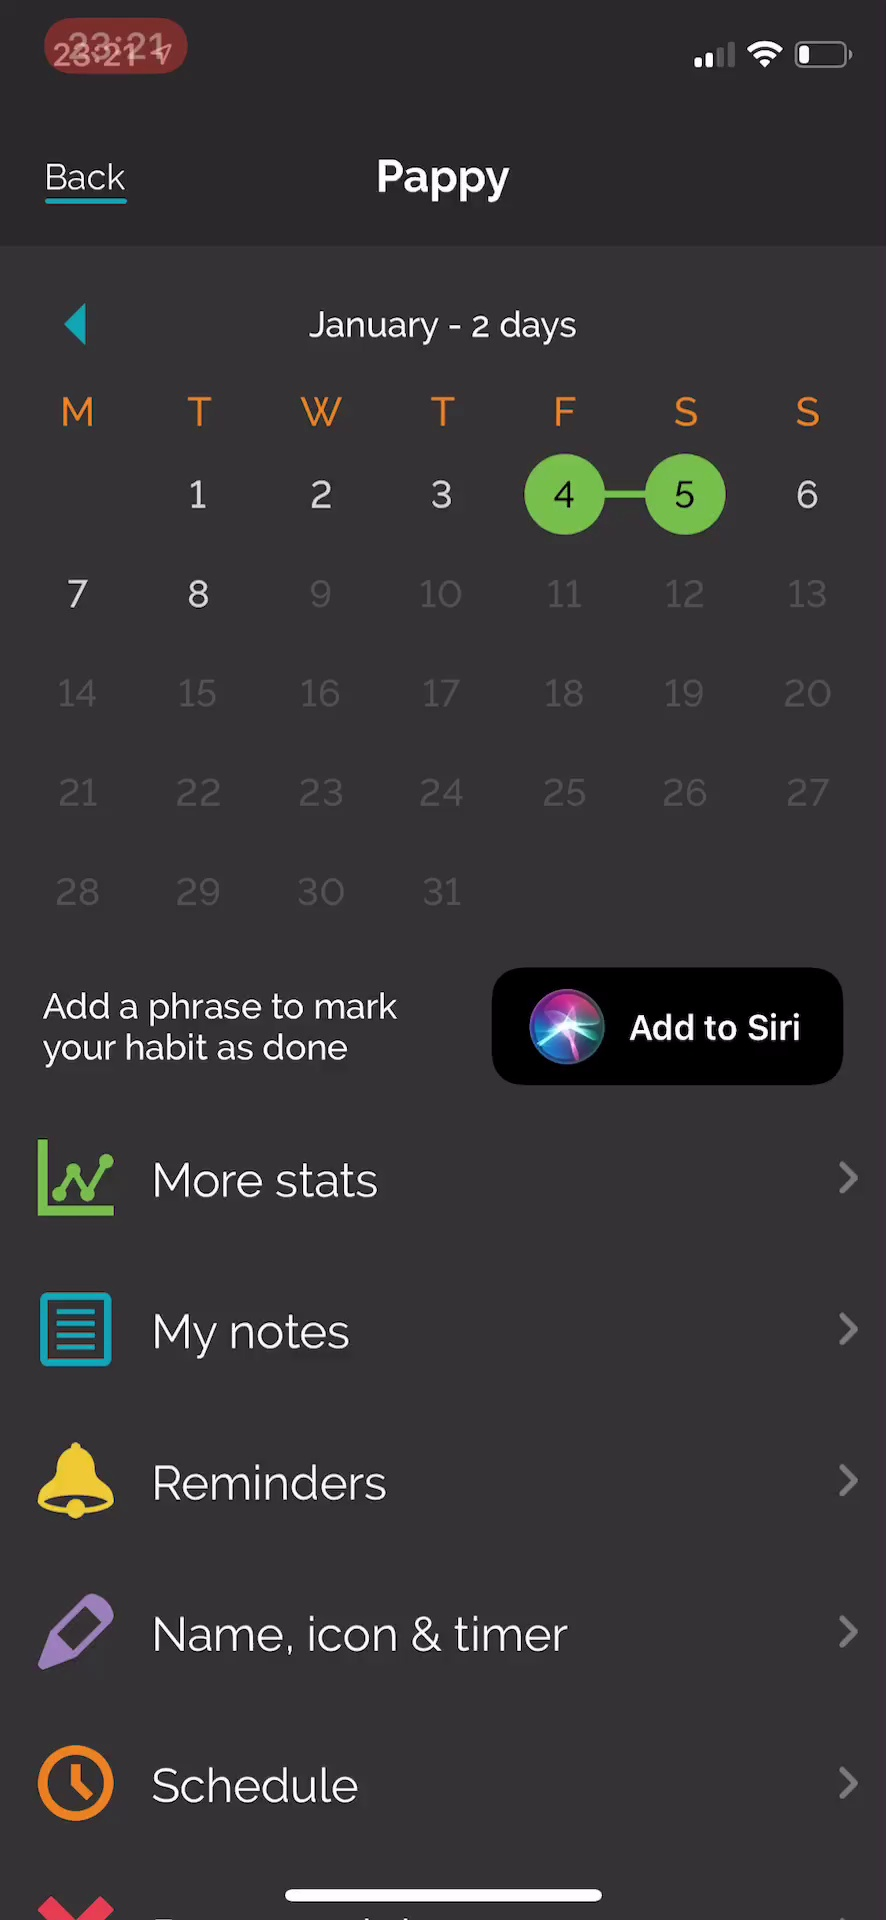

In [316]:
imshow(frame)

In [317]:
print('EAST expects images to be of 32x32 multiple pixel big. Resizing.')

EAST expects images to be of 32x32 multiple pixel big. Resizing.


In [318]:
def resize_image(image, 
                 new_width=width-width%32, 
                 new_height=height-height%32, 
                 crop=True):
    if new_width%32 != 0:
        new_width = new_width - new_width%32
    if new_height%32 != 0:
        new_height = new_height - new_height%32
    print(f'Resizing to: {new_width}x{new_height}. Cropping: {crop}')
    if crop:
        return np.copy(image)[:new_height, :new_width, :]
    else:
        return cv2.resize(image, (new_width, new_height))

In [319]:
sized_frame = resize_image(frame)
# sized_frame = resize_image(sized_frame,
#                           new_width=432,
#                           new_height=960, 
#                            crop=False)
sized_frame.shape

Resizing to: 864x1920. Cropping: True


(1920, 864, 3)

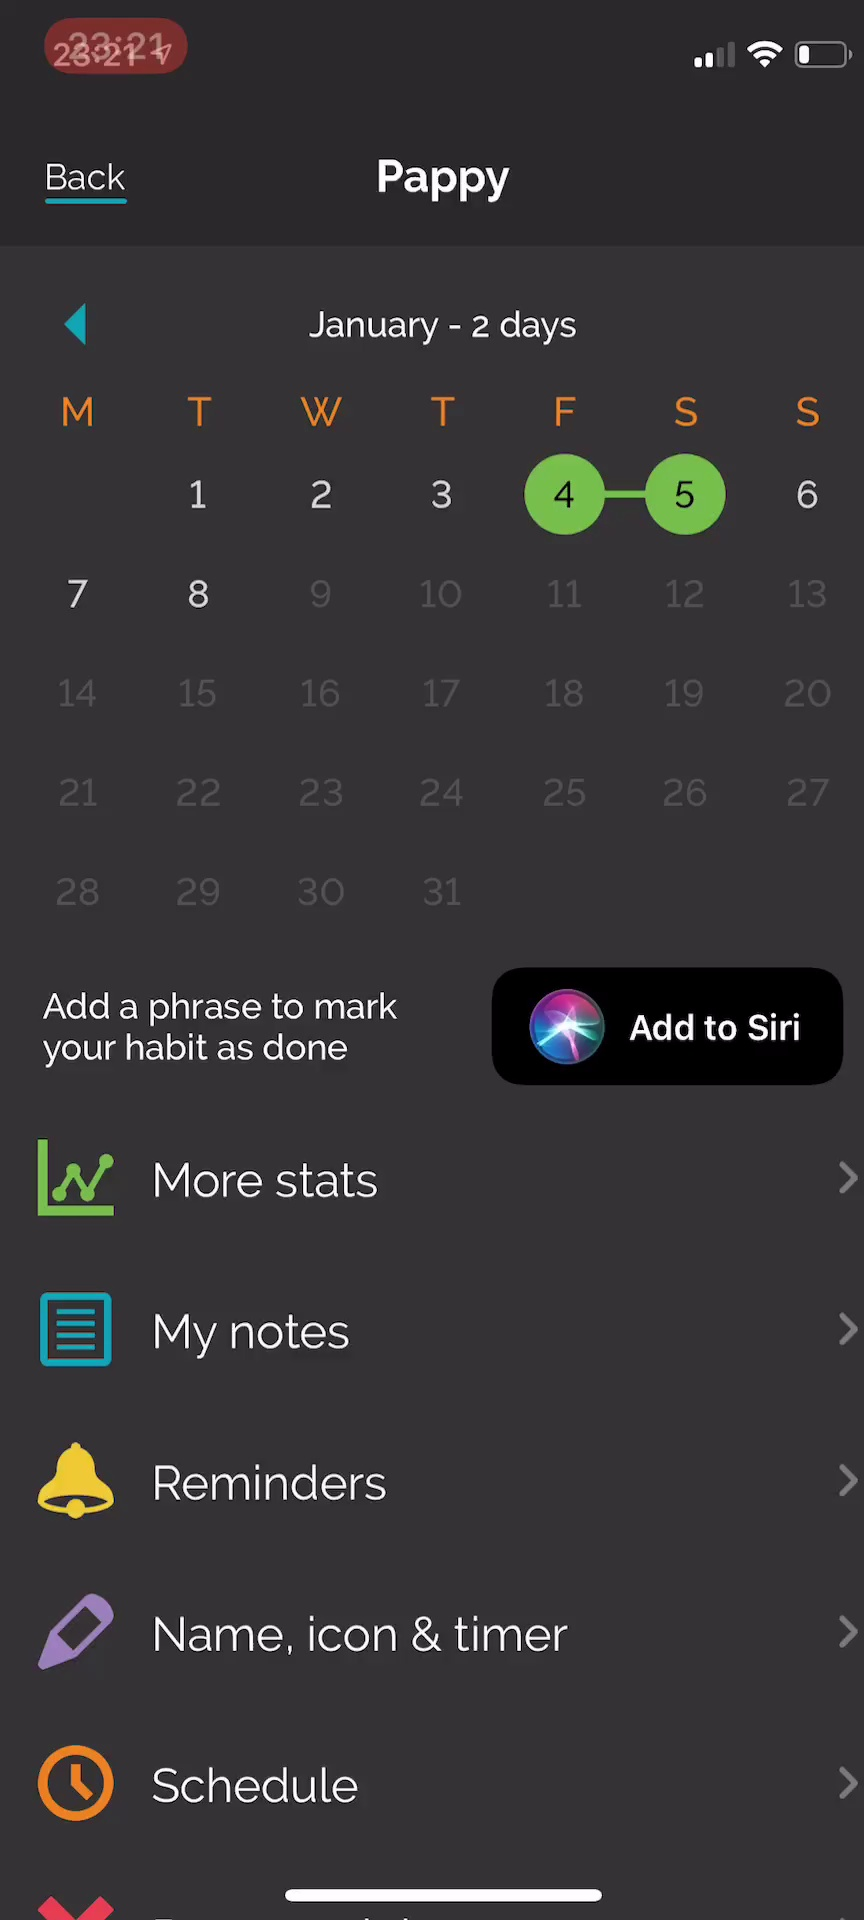

In [320]:
imshow(sized_frame)

In [321]:
# read cnn
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

In [322]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [323]:
new_height, new_width = sized_frame.shape[:2]
print(new_width, new_height)
blob = cv2.dnn.blobFromImage(sized_frame, 1.0, 
                             (new_width, new_height), 
                             (123.68, 116.78, 103.94), 
                             swapRB=True, crop=False)

864 1920


In [324]:
blob.shape

(1, 3, 1920, 864)

In [325]:
start_time = time.time()

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

end_time = time.time()

In [326]:
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end_time - start_time))

[INFO] text detection took 2.568665 seconds


In [327]:
min_confidence = 0.1

In [328]:
# np.count_nonzero(np.array(scores[0,0,:,:numCols]) > min_confidence)

In [329]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
print(numRows, numCols)
rects = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
    # loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < min_confidence:
			continue
 
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
 
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
 
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
 
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

480 216


In [330]:
len(confidences)

2180

In [331]:
from imutils.object_detection import non_max_suppression

In [332]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

rW = width / float(new_width)
rH = height / float(new_height)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
# 	startX = int(startX * rW)
# 	startY = int(startY * rH)
# 	endX = int(endX * rW)
# 	endY = int(endY * rH)
 
	# draw the bounding box on the image
	cv2.rectangle(sized_frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
 

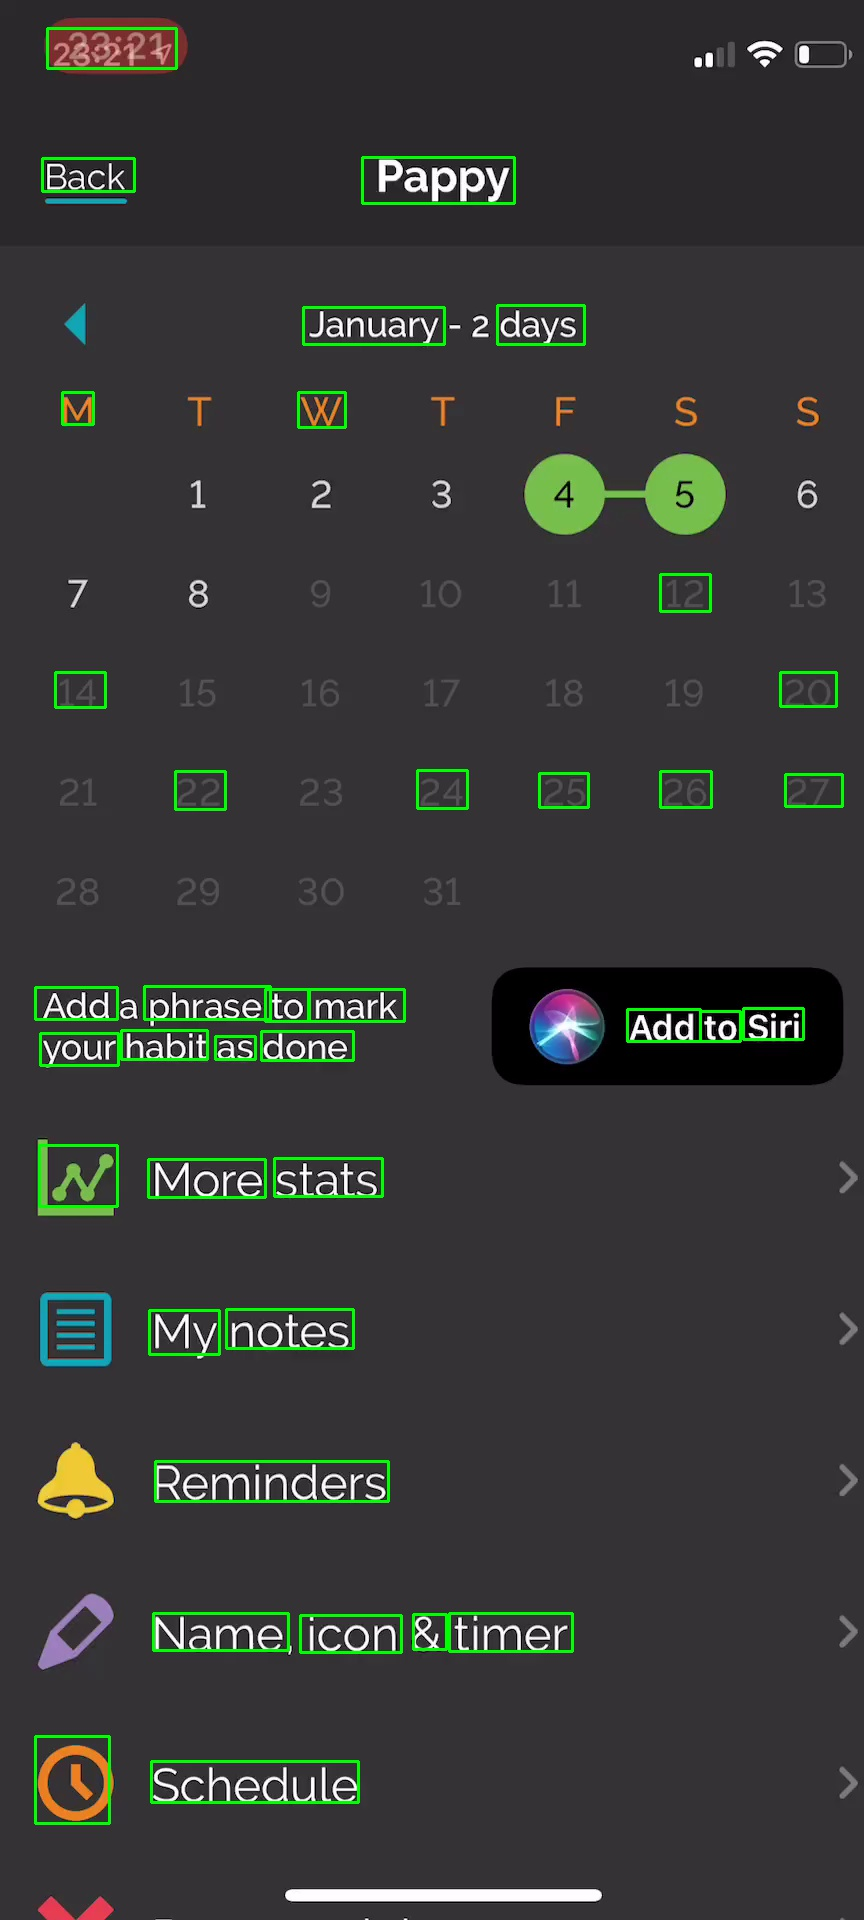

In [333]:
imshow(sized_frame)

In [304]:
sized_frame.shape

(1920, 864, 3)